In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import sklearn
import os
import dill as pickle
from itertools import combinations
import random
import tensorflow as tf

from keras.models import Model, Input, Sequential, load_model
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, ZeroPadding2D, Dropout
from keras.optimizers import SGD,Adam
import keras.metrics
from keras.utils import plot_model
from src.models import history
from keras.callbacks import ModelCheckpoint

from src.data import process_audio
from src.data import display_audio
from src.data import process_audio_siam
from src.models import one_shot_learning
from src.data import process_audio_VGG16_features
from src.models import one_shot_learning_VGG16



In [3]:
%load_ext autoreload
%autoreload 2

# Siamese with VGG16 embeddings - distinct weights

In [38]:
# Define tensors for two input audios
input_shape1 = (7, 7, 512)
input_shape2 = (7, 7, 512)

left_input = Input(input_shape1)
right_input = Input(input_shape2)    

# Left arm
left = Flatten()(left_input) 
encoded_l = Dense(4096, activation='sigmoid')(left)

# Right arm
right = Flatten()(right_input) 
encoded_r = Dense(4096, activation='sigmoid')(right)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_dist_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_dist_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

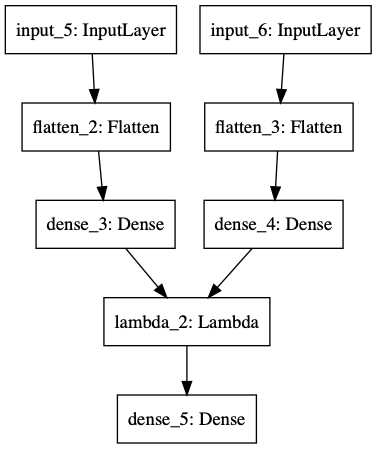

In [39]:
plot_model(siamese_dist_weights)

In [40]:
# Load dataframe:
data_10 = pickle.load(open('/Users/greenapple/project5/data/processed/data_10.pkl', 'rb')) # 10 speakers, 10 audios per speaker
data_10.shape

(100, 4)

In [41]:
# Reshape for the siamese model before modeling:
X_10, y_10, siamese_data_10 = process_audio_VGG16_features.dataframe_to_siamese_features(data_10)
X_10.shape, y_10.shape, siamese_data_10.shape

((9900, 2, 7, 7, 512), (9900,), (9900, 6))

In [14]:
# Data with the inputs from the same speaker (1) versus the inputs from two different speakers (0)  
siamese_data_10.siam_same_id.value_counts()

0    9000
1     900
Name: siam_same_id, dtype: int64

## Epochs 0-5

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 744s 94ms/step - loss: 0.3553 - acc: 0.9045 - val_loss: 0.4179 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.35527, saving model to siamese_dist_weights.h5
Epoch 2/5
7920/7920 [==============================] - 674s 85ms/step - loss: 0.3239 - acc: 0.9082 - val_loss: 0.4657 - val_acc: 0.9091

Epoch 00002: loss improved from 0.35527 to 0.32392, saving model to siamese_dist_weights.h5
Epoch 3/5
7920/7920 [==============================] - 668s 84ms/step - loss: 0.3154 - acc: 0.9091 - val_loss: 0.4586 - val_acc: 0.9091

Epoch 00003: loss improved from 0.32392 to 0.31536, saving model to siamese_dist_weights.h5
Epoch 4/5
7920/7920 [==============================] - 700s 88ms/step - loss: 0.3153 - acc: 0.9088 - val_loss: 0.4465 - val_acc: 0.9091

Epoch 00004: loss improved from 0.31536 to 0.31529, saving model to siamese_dist_weights.h5
Epoch 5/5
7920/7920 [===================

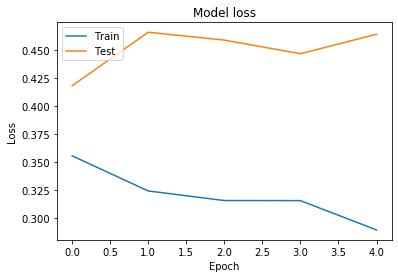

In [42]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_dist_weights.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_dist_weights
history_siamese_dist_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [114]:
pickle.dump(
    history_siamese_dist_weights, 
    open('/Users/greenapple/project5/models/history_siamese_dist_weights.pkl', 'wb'))

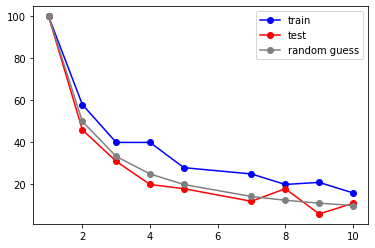

In [43]:
# One shot learning score:
model = siamese_dist_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()   

## Epochs 5-10

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 717s 91ms/step - loss: 0.2756 - acc: 0.9091 - val_loss: 0.4581 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.27559, saving model to siamese_dist_weights.h5
Epoch 2/5
7920/7920 [==============================] - 661s 83ms/step - loss: 0.2596 - acc: 0.9091 - val_loss: 0.4651 - val_acc: 0.9086

Epoch 00002: loss improved from 0.27559 to 0.25964, saving model to siamese_dist_weights.h5
Epoch 3/5
7920/7920 [==============================] - 657s 83ms/step - loss: 0.2430 - acc: 0.9091 - val_loss: 0.4469 - val_acc: 0.9091

Epoch 00003: loss improved from 0.25964 to 0.24297, saving model to siamese_dist_weights.h5
Epoch 4/5
7920/7920 [==============================] - 655s 83ms/step - loss: 0.2244 - acc: 0.9091 - val_loss: 0.4624 - val_acc: 0.9091

Epoch 00004: loss improved from 0.24297 to 0.22437, saving model to siamese_dist_weights.h5
Epoch 5/5
7920/7920 [===================

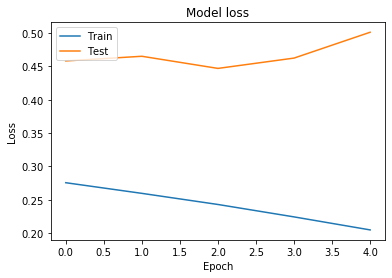

In [22]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_dist_weights.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = load_model(
    '/Users/greenapple/project5/notebooks/siamese_dist_weights.h5'
)
history_siamese_dist_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# Extract embeddings for the test set and organize them in a dataframe.
path = '/Users/greenapple/project5/data/raw/LibriSpeech/test-clean'
speaker_start = 0
speaker_stop = 10

test_data_10 = process_audio_VGG16_features.ten_audio_to_VGG16_features(
    path, speaker_start, speaker_stop)

Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files


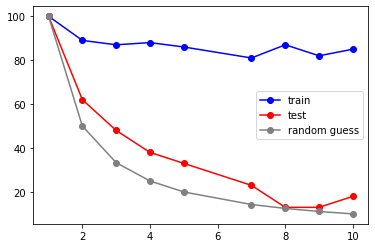

In [33]:
# One shot learning score:
model = load_model(
    '/Users/greenapple/project5/notebooks/siamese_dist_weights.h5')
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    

# Siamese with VGG16 embeddings - same weights

##  Epochs 0-5

In [34]:
# One dense layer
input_shape = (7, 7, 512)   

inputs = Input(input_shape)
output = Flatten()(inputs) 
encodings = Dense(4096, activation='sigmoid')(output)


one_dense = Model(inputs=inputs, outputs=encodings, name='one_dense')
one_dense.compile(optimizer=Adam(lr = 0.00006), 
                  loss='categorical_crossentropy')


# Define tensors for two input audios
input_shape = (7, 7, 512)

left_input = Input(input_shape)
right_input = Input(input_shape)    

encoded_l = one_dense(left_input)
encoded_r = one_dense(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_same_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_same_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

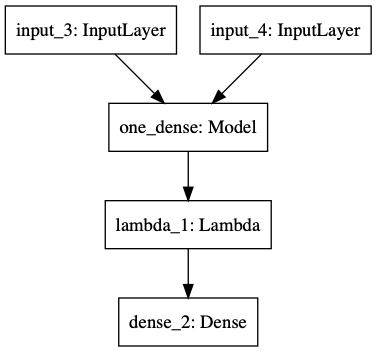

In [35]:
plot_model(siamese_same_weights)

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 516s 65ms/step - loss: 0.2355 - acc: 0.9112 - val_loss: 0.3593 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.23554, saving model to history_siamese_same_weights_5.h5
Epoch 2/5
7920/7920 [==============================] - 491s 62ms/step - loss: 0.0657 - acc: 0.9865 - val_loss: 0.5028 - val_acc: 0.9091

Epoch 00002: loss improved from 0.23554 to 0.06569, saving model to history_siamese_same_weights_5.h5
Epoch 3/5
7920/7920 [==============================] - 485s 61ms/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.5871 - val_acc: 0.9091

Epoch 00003: loss improved from 0.06569 to 0.01604, saving model to history_siamese_same_weights_5.h5
Epoch 4/5
7920/7920 [==============================] - 479s 60ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.6691 - val_acc: 0.9091

Epoch 00004: loss improved from 0.01604 to 0.00654, saving model to history_siamese_same_weights_5.h5


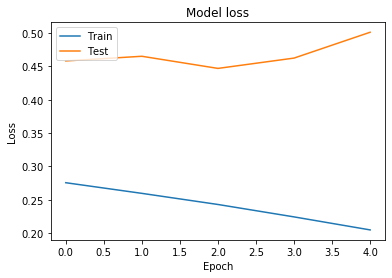

In [36]:
# Train and visualize 
checkpoint = ModelCheckpoint('history_siamese_same_weights_5.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_same_weights
history_siamese_same_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

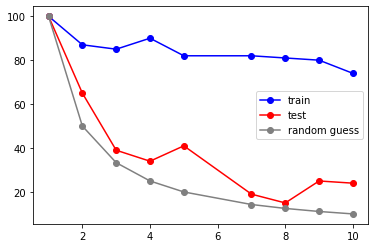

In [37]:
# One shot learning score:
model = siamese_same_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    

## Epochs 5-10

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 496s 63ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.7590 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.00238, saving model to siamese_dist_weights.h5
Epoch 2/5
7920/7920 [==============================] - 467s 59ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.8036 - val_acc: 0.9091

Epoch 00002: loss improved from 0.00238 to 0.00163, saving model to siamese_dist_weights.h5
Epoch 3/5
7920/7920 [==============================] - 465s 59ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.8384 - val_acc: 0.9091

Epoch 00003: loss improved from 0.00163 to 0.00118, saving model to siamese_dist_weights.h5
Epoch 4/5
7920/7920 [==============================] - 499s 63ms/step - loss: 8.8237e-04 - acc: 1.0000 - val_loss: 0.8697 - val_acc: 0.9091

Epoch 00004: loss improved from 0.00118 to 0.00088, saving model to siamese_dist_weights.h5
Epoch 5/5
7920/7920 [===============

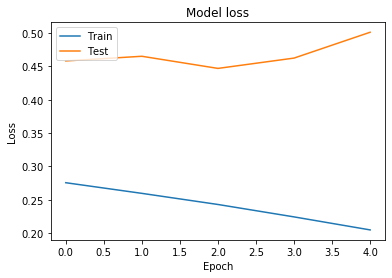

In [26]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_dist_weights.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = load_model(
    '/Users/greenapple/project5/notebooks/siamese_same_weights.h5'
)
history_siamese_same_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

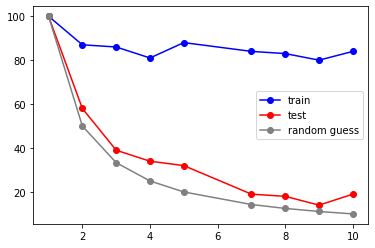

In [31]:
# One shot learning score:
# model = siamese_dist_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()   